1. Ensure you have data structured longitudinally i.e. for each person, have the FEV1 and O2 data as time series.
2. Then run the current ‘point in time model’ (FEV1 only) for each FEV1 measurement for a person.
3. Produce a visualisation of the output of the model which shows all time point at once e.g. have time on the x-axis and some display of the uncertain distributions of the latent variables on the y axis. Could be sideways bar charts or box plots or whatever looks best.
4. Then we need to make a longitudinal model which has all data points at once for an individual. The simplest way to do this is to separate out the lung damage and airway blockage variables (as we always intended) and have **one** lung damage variable shared across all time points. This represents the assumption that lung damage is constant at this time scale. Then have separate blockage variables for each time point. Try to get this model running if you can + update your visualisation to include the extra lung damage latent variable.

In [1]:
import src.data.smartcare_O2_FEV1_df as smartcare_O2_FEV1_df
import src.models.builders as model_lung_health
import src.inference.helpers as ih

import pandas as pd

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

plotsdir = "../../../../PlotsSmartcare/"


def add_heatmap_to_fig(df, ax, colors, title=""):
    df = df.reindex(index=df.index[::-1])
    sns.heatmap(
        df, cmap=colors, annot=True, fmt=".2f", linewidths=0.5, ax=ax, cbar=False
    )
    ax.set_title(title)
    return -1

In [2]:
O2_FEV1 = smartcare_O2_FEV1_df.create()


** Loading measurements data **

* Processing measures *

FEV1
* Analysing same day duplicates *
* Correcting measurements done before 2am *
Dropped 1062 same day FEV1 duplicates
Dropping 1 entries with FEV1 = 3.45 for user Kings004
* Checking for same day measurements *

O2 Saturation
* Analysing same day duplicates *
* Correcting measurements done before 2am *
Dropped 84 same day O2 Saturation duplicates
IDs with O2 Saturation outside 70-100 % range: 
          UserName  O2 Saturation
3575      Kings005            127
4836   Papworth001            127
4911   Papworth002            127
6257   Papworth010            103
6261   Papworth010            104
8131   Papworth027            127
8265   Papworth028            127
8284   Papworth028            127
10854   leeds01222            127
11065   leeds01320            127
Dropping 10 entries with O2 Saturation outside 70-100 % range

Loaded measurements data with 14451 entries (initially 129841, removed 115390)

** Loading ID map **
Cor

/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():



* Dropping unnecessary columns from patient data *
Columns filtered: ['ID', 'Study Date', 'DOB', 'Age', 'Sex', 'Height', 'Weight', 'Predicted FEV1', 'FEV1 Set As']
Columns dropped: {'Remote Monitoring App User ID', 'Transplant Recipients', 'Telemetric Measures', 'GP Letter Sent', 'Hospital', 'Freezer Required', 'Unable Informed Consent', 'Unable Sputum Samples', 'Age 18 Years', 'Date Last PE Start', 'Date Consent Obtained', 'Pulmonary Exacerbation', 'Sputum Samples', 'Comments', 'Study Email', 'Less Exacerbation', 'Informed Consent', 'CFQR Quest Comp', 'Genetic Testing', 'Date Last PE Stop', 'Inconvenience Payment', 'Study Number'}

* Correcting patient data *
ID 60: Corrected height 60 from 1.63 to 163.0
ID 66: Corrected height for ID 66 from 1.62 to 162.0
Replace Age by calculate age
Drop FEV1 Set As and Predicted FEV1
Compute Calculated Predicted FEV1 using GLI reference equations

* Applying data sanity checks *
Loaded patient data with 147 entries (147 initially)

** Creating Dat

# Point-in-time inference across time for HFEV1, AB, FEV1

*** Building lung model with HFEV1 and AB ***


/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/envs/phd/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


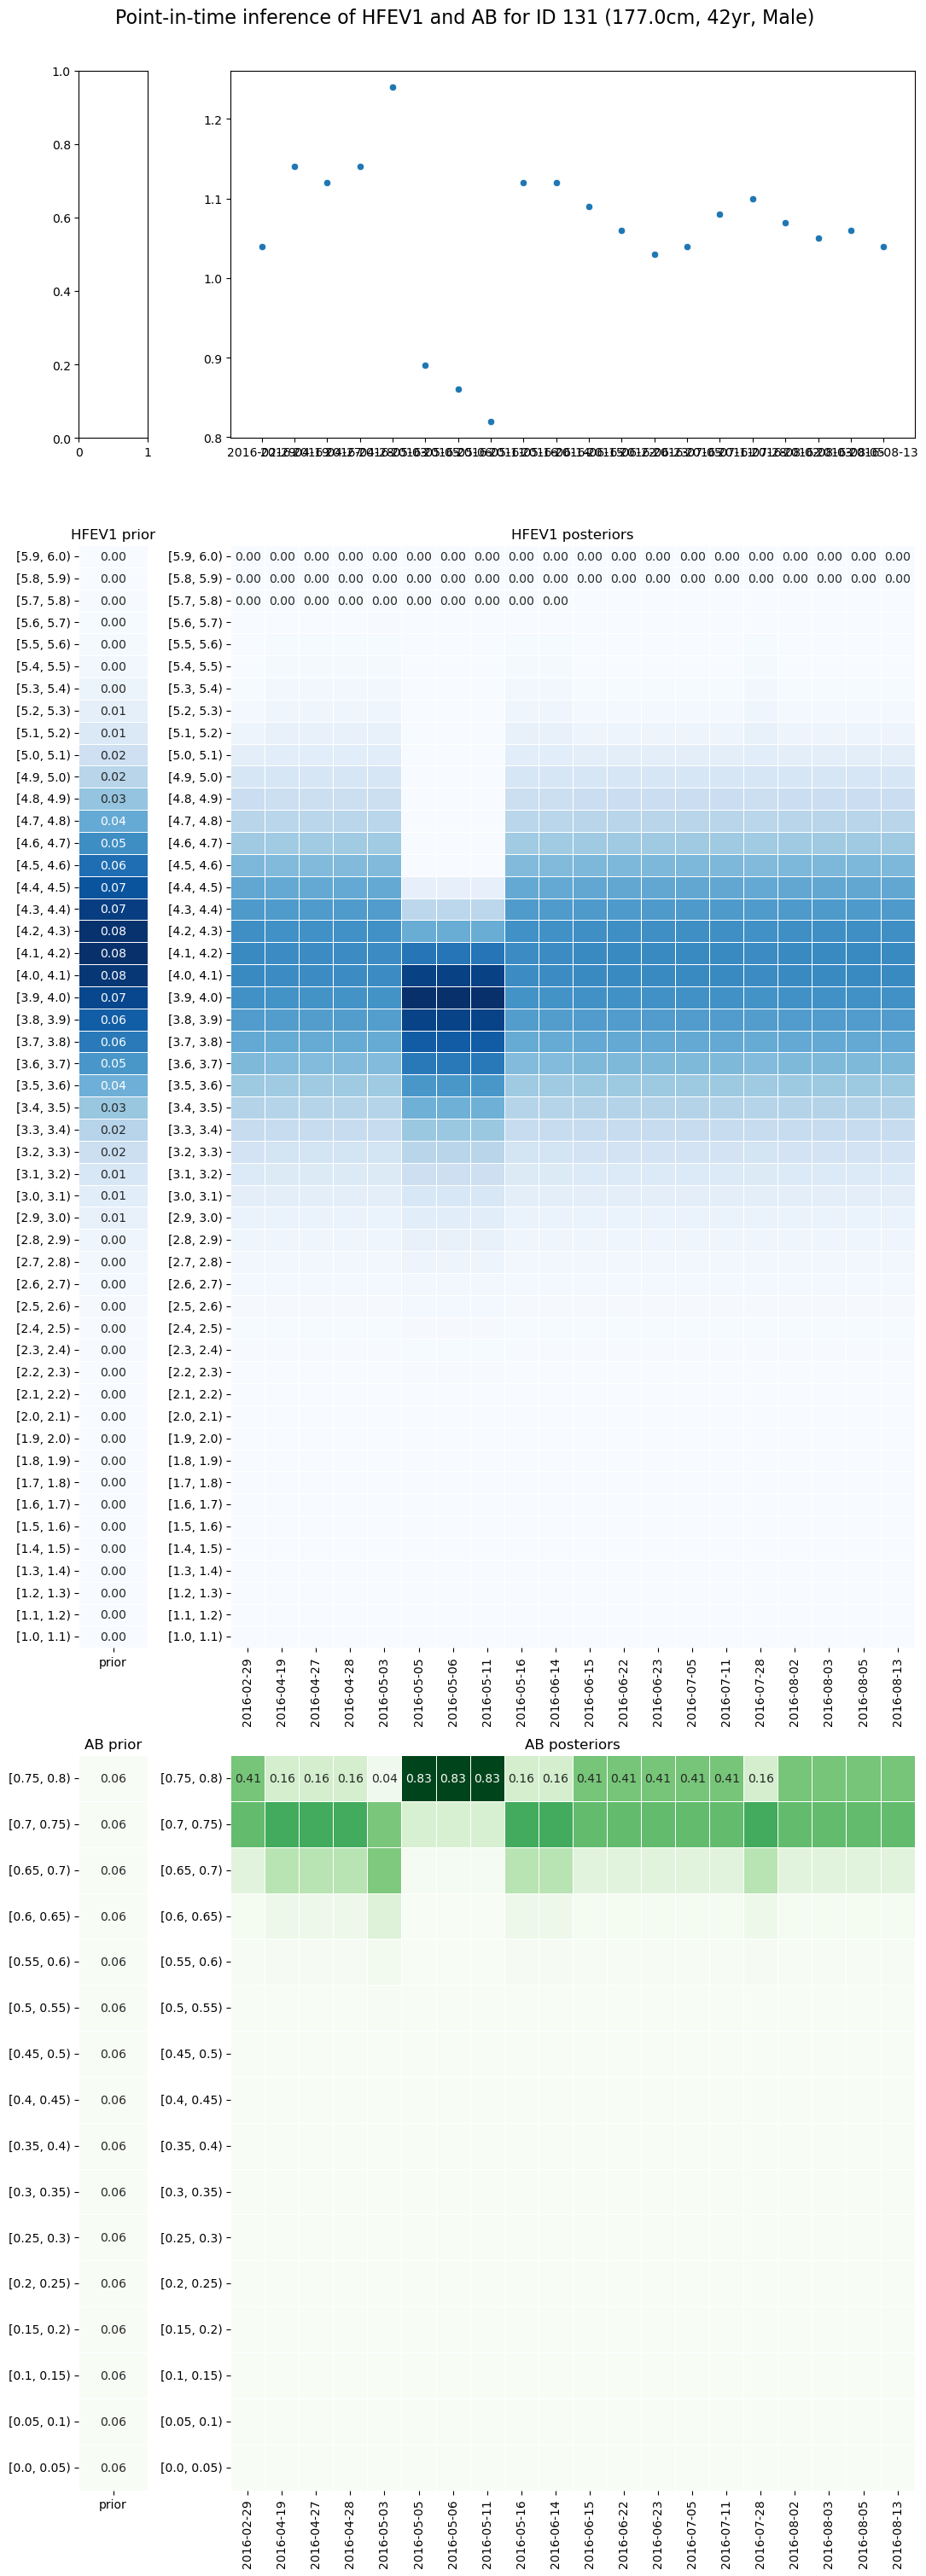

In [3]:
for id in ["131"]:  # O2_FEV1.ID.unique()[0:50]:
    df_for_ID = O2_FEV1[O2_FEV1.ID == id]

    # Create model tailored to patient
    height = df_for_ID.Height.values[0]
    age = df_for_ID.Age.values[0]
    sex = df_for_ID.Sex.values[0]
    HFEV1_prior = {"type": "default", "height": height, "age": age, "sex": sex}
    (
        model,
        inf_alg,
        FEV1,
        HFEV1,
        AB,
    ) = model_lung_health.build_HFEV1_AB_FEV1(HFEV1_prior=HFEV1_prior)

    # Prepare inference
    ## Set data structures for priors
    df_hfev1_prior = pd.DataFrame(
        index=HFEV1.get_bins_str(), columns=["prior"], data=HFEV1.cpt[:, 0]
    )
    df_ab_prior = pd.DataFrame(index=AB.get_bins_str(), columns=["prior"], data=AB.cpt[:, 0])
    ## Set data structures for posteriors
    fev1 = df_for_ID.FEV1.values
    days = df_for_ID["Date Recorded"].astype(str).values
    ## Create empty dataframe of with HFEV1.bins as index name, and days as column names
    df_hfev1_posterior = pd.DataFrame(index=HFEV1.get_bins_str(), columns=days)
    df_ab_posterior = pd.DataFrame(index=AB.get_bins_str(), columns=days)

    # Run inference queries
    for i in range(len(fev1)):
        res_inf = ih.infer(
            inf_alg, [HFEV1, AB], [[FEV1, fev1[i]]], joint=False, show_progress=False
        )
        df_hfev1_posterior[days[i]] = res_inf[HFEV1.name].values
        df_ab_posterior[days[i]] = res_inf[AB.name].values

    # Create heatmap using sns with df_hfev1_posterior index on x, columns on y, coloured by values
    title = f"Point-in-time inference of HFEV1 and AB for ID {id} ({height}cm, {age}yr, {sex})"

    fig, axs = plt.subplots(
        3,
        2,
        figsize=(len(fev1) * 0.5 + 1, 30),
        gridspec_kw={"height_ratios": [1, 3, 2], "width_ratios": [2, len(fev1)]},
    )

    fig.suptitle(title, fontsize=16, y=1.005)
    sns.scatterplot(x=days, y=fev1, ax=axs[0, 1])

    # Add heatmaps of priors and posteriors
    add_heatmap_to_fig(df_hfev1_prior, axs[1, 0], "Blues", "HFEV1 prior")
    add_heatmap_to_fig(df_hfev1_posterior, axs[1, 1], "Blues", "HFEV1 posteriors")
    add_heatmap_to_fig(df_ab_prior, axs[2, 0], "Greens", "AB prior")
    add_heatmap_to_fig(df_ab_posterior, axs[2, 1], "Greens", "AB posteriors")

    plt.tight_layout()
    # plt.savefig(f"{plotsdir}point_in_time_inference/{title}.png")
    # plt.close()

# Point-in-time inference across time for HFEV1, LD, UFEV1, SAB, FEV1

In [ ]:
for id in ["131"]:  # O2_FEV1.ID.unique()[0:50]:
    print("ID: ", id)
    df_for_ID = O2_FEV1[O2_FEV1.ID == id]

    # Create model tailored to patient
    height = df_for_ID.Height.values[0]
    age = df_for_ID.Age.values[0]
    sex = df_for_ID.Sex.values[0]
    HFEV1_prior = {"type": "default", "height": height, "age": age, "sex": sex}
    LD_param = model_lung_health.set_LD_prior(
        df_for_ID.FEV1.values, HFEV1_prior["mu"], HFEV1_prior["sigma"]
    )
    (
        model,
        inf_alg,
        HFEV1,
        LD,
        UFEV1,
        SAB,
        FEV1,
    ) = model_lung_health.build_full_FEV1_side(
        HFEV1_prior=HFEV1_prior, LD_prior=LD_param
    )

    # Prepare inference
    ## Set data structures for priors
    df_ld_prior = pd.DataFrame(
        index=LD.get_bins_str(), columns=["prior"], data=prior_LD.values
    )
    df_hfev1_prior = pd.DataFrame(
        index=HFEV1.get_bins_str(), columns=["prior"], data=prior_HFEV1.values
    )
    df_sab_prior = pd.DataFrame(
        index=SAB.get_bins_str(), columns=["prior"], data=prior_SAB.values
    )

    ## Set data structures for posteriors
    fev1 = df_for_ID.FEV1.values
    days = df_for_ID["Date Recorded"].astype(str).values
    ## Create empty dataframe of with HFEV1.bins as index name, and days as column names
    df_ld_posterior = pd.DataFrame(index=LD.get_bins_str(), columns=days)
    df_hfev1_posterior = pd.DataFrame(index=HFEV1.get_bins_str(), columns=days)
    df_sab_posterior = pd.DataFrame(index=SAB.get_bins_str(), columns=days)
    df_ufev1_posterior = pd.DataFrame(index=UFEV1.get_bins_str(), columns=days)

    # Run inference queries
    for i in range(len(fev1)):
        res = ih.infer(inf_alg, [HFEV1, LD, UFEV1, SAB], [[FEV1, fev1[i]]], joint=False)
        df_sab_posterior[days[i]] = res[SAB.name].values
        df_ufev1_posterior[days[i]] = res[UFEV1.name].values
        df_ld_posterior[days[i]] = res[LD.name].values
        df_hfev1_posterior[days[i]] = res[HFEV1.name].values

    # Create heatmap using sns with df_hfev1_posterior index on x, columns on y, coloured by values
    title = f"Point-in-time inference of HFEV1, LD, UFEV1, SAB, FEV1 for ID {id} ({height}cm, {age}yr, {sex})"

    fig, axs = plt.subplots(
        1 + 4,
        2,
        figsize=(len(fev1) * 0.5 + 1, 40),
        gridspec_kw={
            "height_ratios": [1, 3, 10, 3, 10],
            "width_ratios": [2, len(fev1)],
        },
    )

    fig.suptitle(title, fontsize=16, y=1.005)
    sns.scatterplot(x=days, y=fev1, ax=axs[0, 1])
    axs[0, 0].axis("off")

    # Add heatmaps of priors and posteriors
    ## Order df_hfev1_posterior by index descending (flip index)

    add_heatmap_to_fig(df_sab_prior, axs[1, 0], "Greens")
    add_heatmap_to_fig(df_sab_posterior, axs[1, 1], "Greens", "Small Airway Blockage")

    add_heatmap_to_fig(df_ufev1_posterior, axs[2, 1], "Blues", "Unblocked FEV1")

    add_heatmap_to_fig(df_ld_prior, axs[3, 0], "Reds")
    add_heatmap_to_fig(df_ld_posterior, axs[3, 1], "Reds", "Lung Damage")

    add_heatmap_to_fig(df_hfev1_prior, axs[4, 0], "Blues")
    add_heatmap_to_fig(df_hfev1_posterior, axs[4, 1], "Blues", "Healthy FEV1")

    plt.tight_layout()
    plt.savefig(f"{plotsdir}/point_in_time_inference/{title}.png")
    # plt.close()

# Longitudinal model with LD shared across all times

In [4]:
# TODO: takes 1m16 to run for 1 patient (with 16 days of data)
for id in ["101", "124", "128", "129", "152", "130"]:
    # for id in ['131', '100']:

    print("ID: ", id)
    df_for_ID = O2_FEV1[O2_FEV1.ID == id][0:18]

    # Create model tailored to pat ient
    height = df_for_ID.Height.values[0]
    age = df_for_ID.Age.values[0]
    sex = df_for_ID.Sex.values[0]
    HFEV1_prior = {"type": "default", "height": height, "age": age, "sex": sex}
    (
        model,
        inf_alg,
        HFEV1,
        LD,
        UFEV1,
        SAB_list,
        prior_SAB_i,
        FEV1_list,
    ) = model_lung_health.build_longitudinal_FEV1_side(
        df_for_ID.shape[0], HFEV1_prior=HFEV1_prior
    )

    # Prepare inference
    ## Set data structures for priors
    df_ld_prior = pd.DataFrame(
        index=LD.get_bins_str(), columns=["prior"], data=prior_LD.values
    )
    df_hfev1_prior = pd.DataFrame(
        index=HFEV1.get_bins_str(), columns=["prior"], data=prior_HFEV1.values
    )
    df_sab_i_prior = pd.DataFrame(
        index=SAB_list[0].get_bins_str(), columns=["prior"], data=prior_SAB_i.values
    )

    ## Set data structures for posteriors
    fev1 = df_for_ID.FEV1.values
    days = df_for_ID["Date Recorded"].astype(str).values

    ## Create empty dataframe of with HFEV1.bins as index name, and days as column names
    df_ld_posterior = pd.DataFrame(index=LD.get_bins_str(), columns=["posterior"])
    df_hfev1_posterior = pd.DataFrame(index=HFEV1.get_bins_str(), columns=["posterior"])
    df_ufev1_posterior = pd.DataFrame(index=UFEV1.get_bins_str(), columns=["posterior"])
    df_sab_posteriors = pd.DataFrame(index=SAB_list[0].get_bins_str(), columns=days)

    # Element-wise join of FEV1 var and fev1 evidence
    evidences = list(zip(FEV1_list, fev1))

    # Run inference queries
    print("Run inference queries")
    res = ih.infer(inference, [HFEV1, LD, UFEV1], evidences, joint=False)
    df_hfev1_posterior["posterior"] = res[HFEV1.name].values
    df_ld_posterior["posterior"] = res[LD.name].values
    df_ufev1_posterior["posterior"] = res[UFEV1.name].values

    # Run SAB inference queries
    print("Run SAB inference queries")
    ## Running the inference takes 35s per SAB.
    ## Sometimes running the inference takes only 0.4s
    ## Potential cause: The run crashes when you try to infer too many variables at once because
    ## pgmpy computes the joint distribution of all variables, which hits
    ## numpy's restriction of max 32-dimensional matrices
    for i in range(len(SAB_list)):
        print(f"SAB: {i}")
        res = ih.infer(inf_alg, [SAB_list[i]], evidences, joint=False)
        df_sab_posteriors[days[i]] = res[SAB_list[i].name].values

    # Create heatmap using sns with df_hfev1_posterior index on x, columns on y, coloured by values
    title = (
        f"Longitudinal inference with shared LD (ID {id}, {height}cm, {age}yr, {sex})"
    )

    fig_width = 1 + round(len(fev1) / 2)
    fig = plt.figure(figsize=(round(fig_width * 1.3 + 2), 20))

    # 1 col unit is equivalent to the Index + 1 col, or 2 cols
    gs = GridSpec(nrows=5, ncols=fig_width)

    fig.suptitle(title, fontsize=16, y=1.005)

    ax_scatter = plt.subplot(gs[4, 1:fig_width])
    sns.scatterplot(x=days, y=fev1, ax=ax_scatter)

    # Add heatmaps of priors and posteriors
    ax = plt.subplot(gs[0:3, 0])
    add_heatmap_to_fig(df_hfev1_prior, ax, "Blues")

    ax = plt.subplot(gs[0:3, 1])
    add_heatmap_to_fig(df_hfev1_posterior, ax, "Blues", "Healthy FEV1")

    ax = plt.subplot(gs[1, 3])
    add_heatmap_to_fig(df_ld_prior, ax, "Reds")
    ax = plt.subplot(gs[1, 4])
    add_heatmap_to_fig(df_ld_posterior, ax, "Reds", "Lung Damage")

    ax = plt.subplot(gs[0:3, 6])
    add_heatmap_to_fig(df_ufev1_posterior, ax, "Blues", "Unblocked FEV1")

    ax = plt.subplot(gs[3, 0])
    add_heatmap_to_fig(df_sab_i_prior, ax, "Greens")

    ax = plt.subplot(gs[3, 1:fig_width])
    add_heatmap_to_fig(df_sab_posteriors, ax, "Greens", "Small Airway Blockage")

    plt.tight_layout()
    plt.savefig(f"{plotsdir}longitudinal_inference_shared_ld/{title}.png")
    plt.close()

ID:  101
*** Building the longitudinal model with LD as shared variable across time ***
Defining gaussian prior with mu = 3.03, sigma = 0.35
Run inference queries
Preprocess query
Run query
Query var to list
Find nodes with query vars
Conversion to set of tuple
Compute clique potentials
Variable elimination marginalize


  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd572e560>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcb1cb0a30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd572ff70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcb1cb3700>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcb1cb3fd0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcb1cb3a60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcb1cb0af0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcb1cb2fb0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd572f010>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd572e380>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd572edd0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd572e560>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd572c520>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd572f5e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd572c1f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd572f280>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd572f970>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd1886020>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd572f400>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc680ea080>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd1884400>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd18844c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd1884040>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd1884580>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd572c760>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd572ece0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd572c580>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd572d390>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd572f040>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd572e380>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd572e410>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd572d4b0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd572e410>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd572f010>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd572c0a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd572fbe0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd572c580>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd572c760>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd572d1b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd572c9d0>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd5704d90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcb1cb3af0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd5704e20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcb1cb0910>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcb1cb3430>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcb1cb0ac0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcb1cb3910>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd5704f70>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcb1cb35b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcb1cb3580>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcb1cb3700>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcb1cb37c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcb1cb3190>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcb1cb32e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcb1cb0a30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcb1cb0910>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd572f010>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd572c9d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd572c520>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd572feb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd572d240>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd572d870>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd572fbe0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd572dba0>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd572fd30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd572d240>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd572fbe0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd572c9d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd572ece0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd572f760>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd572e530>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd572faf0>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcb1cb3ca0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcb1cb32e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcb1cb3ee0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcb1cb30d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcb1cb35b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcb1cb3580>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcb1cb3d00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcb1cb37c0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd5707430>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd57074f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd572f9a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd572e920>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd572f6a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd572ece0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd572e530>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd572d150>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd572c9d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd572fd00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd572ece0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd572faf0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd572f760>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd572f040>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd572de10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd572ef50>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd5706cb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcb1cb0ac0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd57066e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcb1cb3ca0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcb1cb3430>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcb1cb35b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcb1cb0a30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcb1cb3910>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd5707100>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd572d120>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd5706290>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd572f280>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd572f850>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd572f010>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd572c0a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd572fd00>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd5706050>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5707eb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd5707f70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5707ee0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5707100>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5705630>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5707790>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd5705690>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd5707970>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5706ef0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd5705b10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd57079d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5706f80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd5705630>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5704460>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5707ee0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd5707850>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5706f80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd5706290>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5705630>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5706ef0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd5704340>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd57076d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5707460>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcb1cb3100>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd572d4b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcb1cb3580>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcb1cb3430>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcb1cb3670>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcb1cb3f70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcb1cb3bb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcb1cb3910>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc61625840>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5707850>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5707be0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5707ca0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5705630>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd5707ee0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5706920>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd57076d0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc04d5cf0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc04d5270>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc04d4e50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc04d6620>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc04d5570>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc04d45b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc04d5a80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc04d68f0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd532a7a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5328340>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd5328e80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd532b220>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5328a90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd532abc0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd532ac50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd53295a0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd532b610>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5329d80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd532af80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd53294b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd532a890>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd532ab60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd53294e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5329ba0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd53294e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5329600>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd53287c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd53292d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd532b4c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd532a230>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5328040>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd532a290>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd532b010>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5328130>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd5328a30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd532a9b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd532a350>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd53298a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd532be20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd532a530>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc60d2d900>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc60d2cfd0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc60d2f2e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc60d2c100>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc60d2ff70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc60d2e1a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc60d2d480>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc60d2f100>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd572d000>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc60d2ff70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd572eb00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc60d2efe0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc60d2ca30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc60d2dab0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc60d2e1a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc60d2c790>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc60d2fac0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd572cb20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc60d2fbe0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd572ceb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc60d2c340>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd572cf70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc60d2cfa0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc60d2c220>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd532bb80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd532b6d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd5329750>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd572ec20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd572cc10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd532b490>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5329c00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd532b4f0>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd532bdc0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd532b070>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd53289d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd572cf70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd572d360>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd5329f90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd572cb80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd532bf70>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd572ce50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd572eb00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5328f40>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd572e8c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd572cac0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd572ef50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd572cf70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd572d360>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd532a230>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd532bb80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd5328f40>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5329120>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5329f00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd5329060>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd532bdc0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd532af80>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd532b1f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd572ec20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd532b4c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd572eb00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd572cac0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd572cc10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd532b940>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd5328310>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd5328640>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd532af80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd532baf0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc04d5210>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc04d4940>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd532a8f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc04d4a60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5328610>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc04d5a50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5329990>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc04d5750>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd532a230>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd532aa10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5328f40>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc04d51b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcc04d6110>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc05665c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc04d59c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0566470>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc04d4a90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc04d55a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc04d4e50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc04d4340>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc04d4df0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0566620>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc04d5810>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0565450>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc04d62c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc04d6110>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0565480>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc04d65f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc04d6d10>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc04d51e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc04d6410>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc04d5540>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc04d6620>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc04d40d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc04d69e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc04d5210>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcc04d4bb0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc04d6b30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc04d6800>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc04d6110>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc04d59c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc04d5750>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc04d4e80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc04d68f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcc04d50c0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d0250>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d0280>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d0400>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d00a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d02e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d03a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d0310>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d0370>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d0640>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d0670>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d0460>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d21a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d0610>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d0550>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d0580>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d04c0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d1b10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d05b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d0160>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d1e40>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d04f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d0580>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d23b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d1210>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d2740>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d1840>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d1720>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d1d20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d0040>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d1870>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d30d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d30a0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d3610>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d3850>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d16f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d1ae0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d0640>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d17e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d1870>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc709d3f40>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d2920>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d1570>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d1900>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d15a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d0130>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d1750>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d1c90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc709d1d20>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d2200>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d3820>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d0d00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d0cd0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d15a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d17b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d1900>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d1780>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d3730>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d3d30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d0dc0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d2410>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d1780>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d27a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d0cd0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc709d09a0>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d1b70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d02e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d1e10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d2d10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d2500>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d2260>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d3fd0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc709d2020>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d11b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d1b40>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d1990>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d1c90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d15a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d23b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d27d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d1720>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d30d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d2110>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d2260>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d3940>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d3550>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d2b60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d1870>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc709d2d10>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d3a00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d3280>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc70a05fc0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d29e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d11b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d2a40>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d1e10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc709d34f0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d3820>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d18a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d3fa0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d2260>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d1960>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d1030>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d0d00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc709d1db0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d27a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d3400>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d3220>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d3a00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d3280>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d1780>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d0c40>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d2d10>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc70a06fb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d1db0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc70a06f80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d3940>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d3640>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d0130>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d2d10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc709d1210>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d11b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d05e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d3a00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d23b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d0340>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d1960>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d2260>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d3220>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc709d18a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d3550>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d1e10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d2500>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d02e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d34f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d3fa0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d3820>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d3a00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc709d0c40>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d08b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d3940>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d1b40>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d0550>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d3400>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc709d1510>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc70a07eb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc709d1510>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc709d3a00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc709d1780>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc709d3310>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc709d0dc0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc709d3640>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc709d08b0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc9372ad70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc937299f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc93729750>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc93729f00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc93729240>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc93729ed0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc93729f60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc93729d50>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e3b100>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc0e393c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e396f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc9372a8f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc93729450>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0e3afb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc9372aef0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc0e3b0d0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e39690>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc0e3b100>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e38640>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc0e38be0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc0e39660>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0e396f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc0e3afb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc0e38670>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e3b520>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc0e3a5f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e39390>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc0e3a6e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc0e3b550>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0e39690>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc0e39480>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc0e394e0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e3a770>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc0e3b280>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e3af50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc0e38040>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc0e3aec0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0e38730>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc0e3aef0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcc0e38f10>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e3be80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc0e38730>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e3af50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc0e3b2b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0e38040>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc0e3ae60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc0e3a770>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcc0e3bdc0>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e3bf40>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc0e3bcd0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e39900>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc0e3ae00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc0e3b970>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0e38be0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc0e3b100>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc0e3ae60>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e3a950>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc0e3b130>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e3be50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc0e3bdc0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0e3b8e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc0e3b970>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc0e39810>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcc0e3b940>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e3a500>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc0e39840>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e39900>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc0e39b70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc0e3bdc0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0e3be50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc0e3b8e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcc0e3b730>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e386a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc0e3ae30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e3ae60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc0e39b10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc0e3b070>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0e39960>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc0e3ab90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc0e3a830>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e3ab00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e3b910>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc0e386a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc0e3bee0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0e39e10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc0e3bca0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc0e3b100>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcc0e3b2e0>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e392a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc0e3bd30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e3bc10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc0e3b070>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc0e3b730>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcc0e3ae60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc0e3aef0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcc0e3ab90>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcc0e3a320>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcc0e3ab90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcc0e3b730>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcc0e3a650>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcc0e39b10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcc0e392a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcc0e3ae60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcc0e3aef0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc93729570>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc93729120>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc937299f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc9372a230>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc9372add0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc9372aa10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc93729360>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc9372ad70>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc9372ac20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc9372a410>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc93729b70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc93729240>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc93729ed0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc9372b670>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc937295a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc9372afb0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc9372a920>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc9372a350>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc9372a9e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc93729360>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc9372afe0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc93729060>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc93729a50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc93729420>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd6206ec0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc9372a8f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd62069e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc9372a7d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc93729450>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc93729690>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc93729060>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc9372a410>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc9372aa70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc9372a830>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc9372a350>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc9372b220>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc93729240>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc9372a9b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc9372b9a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc93729510>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc937298d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc9372a9e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc93729c90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc9372b130>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc9372ae90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc93729570>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc937299f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc9372b4f0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c7550>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c5510>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c7940>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c5ab0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c4e20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc6a2c4bb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c5570>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c5780>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c48b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c4a60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c7790>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c5810>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c7940>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc6a2c7700>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c5f90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c5060>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c5810>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c4970>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c7790>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c4a90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c7a60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc6a2c5600>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c6230>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 0 (%):16) at 0x7fbc6a2c7d30>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c6fb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c7af0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c7b20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c5030>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c5810>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc6a2c6e30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c5f90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 0 (%):16) at 0x7fbc6a2c5960>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c4a90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c58a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c6290>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c5fc0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc6a2c6b00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c6830>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c5990>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 0 (%):16) at 0x7fbc6a2c69b0>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c6680>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c5090>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c6110>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc6a2c5fc0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c5060>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c7ee0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c6e60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 0 (%):16) at 0x7fbc6a2c5c60>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c7790>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c6aa0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c57b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c6bf0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c5750>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc6a2c4df0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c67a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c4ca0>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c5c60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c5f90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c4c70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc702a5840>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c6e00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c4ca0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c59c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 0 (%):16) at 0x7fbc6a2c6950>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c7d30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c6aa0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc6a2c6e60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c5060>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c6e00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c6a10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c6f20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 0 (%):16) at 0x7fbc6a2c6950>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c4850>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c5480>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c6ec0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c7b20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c5f90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc6a2c62c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c6020>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c4c70>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c6e60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c6f20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c5ed0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c6b30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc702a4a30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c5060>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c4cd0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 0 (%):16) at 0x7fbc6a2c63b0>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c6560>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c51e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c58a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c7a60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc6a2c7160>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c7af0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c7340>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 0 (%):16) at 0x7fbc6a2c7730>]
factors: [<DiscreteFactor representing phi(Unblocked FE

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c6230>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c6ce0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c6830>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c51e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c6950>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c5960>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c4ca0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 0 (%):16) at 0x7fbc6a2c6e90>]
factors: [<DiscreteFactor representing phi(Unblocked FE

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc702a6590>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c6830>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c58a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c6560>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc702a6d70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 13 (%):16) at 0x7fbc702a73d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c6b30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c4d90>]
factors: [<DiscreteFactor representing phi(Unblocked F

  0%|          | 0/14 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc6a2c6e60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc6a2c6230>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc6a2c5180>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc6a2c7730>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc6a2c7130>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 2 (%):16) at 0x7fbc6a2c6e90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 1 (%):16) at 0x7fbc6a2c5ba0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 0 (%):16) at 0x7fbc6a2c5f00>]
factors: [<DiscreteFactor representing phi(Unblocked FE

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd5431d20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5430340>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd54301f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5430430>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd54304c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd5430310>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5433d00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5430520>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc70259630>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd54300a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc70259660>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd54306a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd54302b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd5433d60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5430040>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5433940>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc70259ba0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5431f90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc70258c10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5432b90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd54303d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd5430df0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5430430>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5430310>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc7025a260>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5432950>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc70259930>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5431030>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5430220>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd5430e50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5431f90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5430910>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc702598a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5431f90>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc7025a920>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5433c70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5430c70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd54323b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5431390>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc70258a30>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc7025b460>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc7025b3d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc7025b3a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd54329b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc7025b430>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5432d10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc7025b340>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc7025b400>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc7025aa70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc702598a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc7025aec0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5432170>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd54326b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc7025ae00>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5430f10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc702586a0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc70259090>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc7025ace0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc7025b0d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5433190>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc7025a290>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5433d30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc70258ee0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc7025b070>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc7025a410>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc7025b3a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc702594e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5430310>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc7025be50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc70258130>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc70258490>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc702598d0>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc7025a230>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc7025a050>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc7025bd60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5433a60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5433ca0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc7025b340>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc7025bf10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc7025be80>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc7025a410>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc7025b310>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5430340>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc7025b370>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc70258bb0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc7025a110>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc7025a890>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc70259600>]
factors: [<DiscreteFactor representing phi(Unblocke

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc7025a110>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc70259d20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc7025b7c0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5433580>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc70259180>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc7025abf0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc7025bb20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc7025b8b0>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc7025af80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc7025b370>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc7025b1f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5431420>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc7025b5e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc7025be50>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc7025a410>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbc7025a740>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc7025a230>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbc7025bfd0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc7025a410>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbc7025a110>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbc7025b970>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbc70259300>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbc7025be80>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbc7025bb20>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbc6a5e1f60>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5432650>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc6a5e1960>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5432230>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5431750>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd54323b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd54322f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd5431b70>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd5431b70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5432530>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd54301f0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5431db0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5432a70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd54305b0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5431ae0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5433a60>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd54318a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5431510>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbcd5431390>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5432d70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5432110>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd54303d0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5431b10>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5430940>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5433ca0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 17 (%):16) at 0x7fbc6a5e2590>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5431a20>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5430370>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd54312a0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5431390>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd54317e0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd5432890>]
factors: [<DiscreteFactor representing phi(Unblocked

  0%|          | 0/18 [00:00<?, ?it/s]

factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 16 (%):16) at 0x7fbcd5432bf0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 9 (%):16) at 0x7fbcd5431ae0>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 3 (%):16) at 0x7fbcd5431420>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 7 (%):16) at 0x7fbcd5430310>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 6 (%):16) at 0x7fbcd5431e70>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 11 (%):16) at 0x7fbcd5430a30>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 10 (%):16) at 0x7fbcd5431270>]
factors: [<DiscreteFactor representing phi(Unblocked FEV1 (L):58, Small Airway Blockage 14 (%):16) at 0x7fbcd5433a90>]
factors: [<DiscreteFactor representing phi(Unblocked

In [ ]:
# model.get_cpds()

# nx.draw(
#     model,
#     with_labels=True,
#     node_size=2000,
#     node_color="skyblue",
#     node_shape="o",
#     alpha=0.7,
#     linewidths=5,
# )
# plt.show()
# model.nodes()

In [6]:
fig = plt.figure(figsize=(10, 20))
plt.savefig(f"{plotsdir}/longitudinal_inference_shared_ld/hey.png")

<Figure size 720x1440 with 0 Axes>